# Robert Chatterton

#### DS 4400 Machine Learning and Data Mining I Final Project

<hr />

## Authorship Attribution on Classical Works and More

### Outline       

- Models:
    - SVM
    - Random Forest
    - Naive Bayes
    - CNN

# Data Cleaning

- Clean and pull data
    - Read in texts from NLTK
    - Choose specific ones (5 authors?)

In [104]:
# cleaning imports
import numpy as np
import nltk
import random
import pandas as pd

RANDOM_SEED = 3
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

nltk.download('gutenberg')
nltk.download('punkt')

[nltk_data] Downloading package gutenberg to /home/robbie/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /home/robbie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [105]:
minimum_sentence_length = 0

def create_sentence_list(work):
    raw = nltk.corpus.gutenberg.raw(work)
    
    # fix up text
    text = raw.replace('."', '".').replace('?"', '"?').replace('!"', '"!')
    text = text.replace('--', ' ').replace('. . .', '').replace('_', '')
    text = text.replace('\n', ' ').replace('  ', ' ').replace('  ', ' ')

    # tokenize into sentences
    sents = nltk.tokenize.sent_tokenize(text)

    # remove short sentences
    sents = [sent for sent in sents if len(sent) > minimum_sentence_length]
    print(f'{work} has {len(sents)} sentences')
    return sents

# authors and works to investigate
austen = create_sentence_list('austen-persuasion.txt') + create_sentence_list('austen-sense.txt')
chesterson = create_sentence_list('chesterton-ball.txt') + create_sentence_list('chesterton-brown.txt') + create_sentence_list('chesterton-thursday.txt')
shakespeare = create_sentence_list('shakespeare-caesar.txt') + create_sentence_list('shakespeare-hamlet.txt') + create_sentence_list('shakespeare-macbeth.txt')

works = {
    'austen': austen, 
    'chesterson': chesterson, 
    'shakespeare': shakespeare
}

for a, w in works.items():
    print(f'{a} has {len(w)} sentences total')

austen-persuasion.txt has 3657 sentences
austen-sense.txt has 5195 sentences
chesterton-ball.txt has 4636 sentences
chesterton-brown.txt has 3727 sentences
chesterton-thursday.txt has 3570 sentences
shakespeare-caesar.txt has 1592 sentences
shakespeare-hamlet.txt has 2355 sentences
shakespeare-macbeth.txt has 1465 sentences
austen has 8852 sentences total
chesterson has 11933 sentences total
shakespeare has 5412 sentences total


Choose random sentences for training

In [106]:
# slightly lower than least amount of sentences of any author
to_choose = 4500
sentences = []
sentence_labels = []

for author, sents in works.items():
    chosen = np.random.choice(sents, to_choose, replace=False)
    sentences += list(chosen)
    sentence_labels += [author] * to_choose

# shuffle list randomly
Xy = list(zip(sentences, sentence_labels))
random.shuffle(Xy)
X, y = zip(*Xy)

df = pd.DataFrame()
df['sentence'] = X
df['author'] = y
df

,sentence,author
0,With a smart journalistic instinct characteris...,chesterson
1,In his preceding attempts to attach himself to...,austen
2,I must see what I can give them towards furnis...,austen
3,Hor.,shakespeare
4,Clit.,shakespeare
...,...,...
13495,"As it is, I must ask you to announce that the ...",chesterson
13496,"With a hasty exclamation of Misery, and a sign...",austen
13497,"One leg gave way, he was swung round and sucke...",chesterson
13498,"That you bend your eye on vacancie, And with t...",shakespeare


In [107]:
# each author has 4500 selected sentences
len(np.where(df['author'] == 'chesterson')[0]), len(np.where(df['author'] == 'austen')[0]), len(np.where(df['author'] == 'shakespeare')[0])

(4500, 4500, 4500)

# Prepare Data

- Prepare data
    - Normalize
        - convert to lowercase
        - remove punctuation
    - N-grams
    - Bag of Words
    - word2Vec ?
    - Get style
        - sentence length
        - word choice
        - sentiment ?

In [108]:
import collections
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from keras.preprocessing.text import one_hot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/robbie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/robbie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/robbie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [109]:
def get_vocab_size(excerpt_list, n, seq_size):
    """Calculate size of n-gram vocab
    
    Args:
    excerpt_list: list of strings. List of normalized text excerpts.
    n: int. Length of n-grams.
    seq_size: int. Size of n-gram sequences
    
    Returns:
    vocab_size: int. Size of n-gram vocab.
    """
    n_gram_list = []

    for excerpt in excerpt_list:
        # Remove spaces
        excerpt = excerpt.replace(" ", "")

        # Extract n-grams           
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        # Create list of n-grams
        gram_len = len(n_grams)
        if gram_len >= seq_size:
            n_grams = n_grams[0:seq_size]
        else:
            diff = seq_size - gram_len
            extra = [0]*diff
            n_grams = n_grams + extra
        
        n_gram_list.append(n_grams)
    
    # Flatten n-gram list
    n_gram_list = list(np.array(n_gram_list).flat)
    
    # Calculate vocab size
    n_gram_cnt = collections.Counter(n_gram_list)
    vocab_size = len(n_gram_cnt)
    
    return vocab_size

def create_n_grams(excerpt_list, n, vocab_size, seq_size):
    """Create a list of n-gram sequences
    
    Args:
    excerpt_list: list of strings. List of normalized text excerpts.
    n: int. Length of n-grams.
    vocab_size: int. Size of n-gram vocab (used in one-hot encoding)
    seq_size: int. Size of n-gram sequences
    
    Returns:
    n_gram_array: array. Numpy array of one-hot encoded n-grams.
    """
    n_gram_list = []

    for excerpt in excerpt_list:
        # Remove spaces
        excerpt = excerpt.replace(" ", "")

        # Extract n-grams
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        # Convert to a single string with spaces between n-grams
        new_string = " ".join(n_grams)

        # One hot encode
        hot = one_hot(new_string, round(vocab_size*1.3))

        # Pad hot if necessary
        hot_len = len(hot)
        if hot_len >= seq_size:
            hot = hot[0:seq_size]
        else:
            diff = seq_size - hot_len
            extra = [0]*diff
            hot = hot + extra

        n_gram_list.append(hot)
    
    n_gram_array = np.array(n_gram_list)
    
    return n_gram_array

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [111]:
train_vs = get_vocab_size(X_train, 3, 350)
test_vs = get_vocab_size(X_test, 3, 350)
print(train_vs, test_vs)

18919 13411


In [112]:
three_grams_train = create_n_grams(X_train, 3, train_vs, 350)
three_grams_test = create_n_grams(X_test, 3, test_vs, 350)
three_grams_train.shape, three_grams_test.shape, np.max(three_grams_train), three_grams_train[0]

((10125, 350),
 (3375, 350),
 24592,
 array([ 4532, 11965, 17660,  5563, 10804,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     

In [113]:
# normalize texts
def normalize_text(excerpt_list):
    """
    Lemmatize sentences, remove stopwords and split into word lists
    
    Args:
    excerpt_list: list of strings. List of normalized text excerpts.
    
    Returns:
    processed: list of strings. List of lists of processed text excerpts (stemmed and stop words removed).
    """
    stop_words = set(stopwords.words('english'))
    lemma = WordNetLemmatizer()
    
    processed = []
    
    for excerpt in excerpt_list:
        new = excerpt.split()
        word_list = [lemma.lemmatize(w.lower(), pos='v') for w in new if not w in stop_words] # lemmatize verbs
        word_list = [lemma.lemmatize(w.lower(), pos='n') for w in new if not w in stop_words] # lemmatize nouns
        word_list = [lemma.lemmatize(w.lower(), pos='a') for w in new if not w in stop_words] # lemmatize adjectives
        word_list = [lemma.lemmatize(w.lower(), pos='r') for w in new if not w in stop_words] # lemmatize adverbs
        word_list = [lemma.lemmatize(w.lower(), pos='s') for w in new if not w in stop_words] # lemmatize satellite adjectives
        word_list = " ".join(word_list)
        processed.append(word_list)
    
    return processed

In [114]:
processed_train = normalize_text(X_train)
processed_test = normalize_text(X_test)
processed_train[150]

"she roused broodings restless agitation, let mrs clay know seen mr elliot three hours supposed bath, watched vain intimation interview lady herself, determined mention it, seemed guilt mrs clay's face listened."

In [115]:
# create features
vector = TfidfVectorizer(strip_accents='ascii', stop_words='english')
vector.fit(processed_train)

words_train = vector.transform(processed_train)
words_test = vector.transform(processed_test)

In [116]:
# encode author labels
lb = LabelBinarizer()
lb.fit(y_train)
author_one_hot_train = lb.transform(y_train)
author_one_hot_test = lb.transform(y_test)

# Implement Models

In [123]:
import tensorflow as tf

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras.callbacks import ModelCheckpoint

# try to get optimizer to work later
# from keras.optimizers import Adam 

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


## SVM

In [127]:
svm = SVC()

# attempt a bunch of different parameters to find best
params = {'C':[1, 10, 100], 'kernel': ['linear', 'poly', 'sigmoid']}
scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(svm, params, scoring = scorer, verbose = 50)
svm_model = grid_obj.fit(words_train, y_train)

# best model
svm_model.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START C=1, kernel=linear..........................................
[CV 1/5; 1/9] END ...........C=1, kernel=linear;, score=0.868 total time=   5.0s
[CV 2/5; 1/9] START C=1, kernel=linear..........................................
[CV 2/5; 1/9] END ...........C=1, kernel=linear;, score=0.859 total time=   5.0s
[CV 3/5; 1/9] START C=1, kernel=linear..........................................
[CV 3/5; 1/9] END ...........C=1, kernel=linear;, score=0.862 total time=   4.9s
[CV 4/5; 1/9] START C=1, kernel=linear..........................................
[CV 4/5; 1/9] END ...........C=1, kernel=linear;, score=0.863 total time=   5.2s
[CV 5/5; 1/9] START C=1, kernel=linear..........................................
[CV 5/5; 1/9] END ...........C=1, kernel=linear;, score=0.874 total time=   4.9s
[CV 1/5; 2/9] START C=1, kernel=poly............................................
[CV 1/5; 2/9] END .............C=1, kernel=poly;,

SVC(C=1, kernel='linear')

In [128]:
svc_model = SVC(C=1, kernel='linear')
svc_model.fit(words_train, y_train)

SVC(C=1, kernel='linear')

## Random Forest Ensemble

## Naive Bayes Classifier

## CNN

In [118]:
# Define model architecture in keras
# Code reference: https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/
def define_model(input_len, output_size, vocab_size, embedding_dim, verbose = True,
                drop_out_pct = 0.25, conv_filters = 500, activation_fn = 'relu', pool_size = 2, learning = 0.0001):
    """Define n-gram CNN
    
    Args:
    input_len: int. Length of input sequences.
    output_size: int. Number of output classes.
    vocab_size: int. Maximum value of n-gram encoding.
    embedding_dim: int. Size of embedding layer.
    verbose: bool. Whether or not to print model summary.
    drop_out_pct: float. Drop-out rate.
    conv_filters: int. Number of filters in the conv layer.
    activation_fn: string. Activation function to use in the convolutional layer.
    pool_size: int. Pool size for the max pooling layer.
    learning: float. Learning rate for the model optimizer.
    
    Returns:
    model: keras model object. 
    """
    # Channel 1
    inputs1 = Input(shape = (input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters = conv_filters, kernel_size = 3, activation = activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size = pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    # Channel 2
    inputs2 = Input(shape = (input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters = conv_filters, kernel_size = 4, activation = activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size = pool_size)(conv2)
    flat2 = Flatten()(pool2)

    # Channel 3
    inputs3 = Input(shape = (input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters = conv_filters, kernel_size = 5, activation = activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size = pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    # Merge channels
    merged = concatenate([flat1, flat2, flat3])
    
    # Create output layer
    output = Dense(output_size, activation = 'softmax')(merged)
    
    # Create model
    model = Model(inputs = [inputs1, inputs2, inputs3], outputs = output)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

In [119]:
three_gram_model = define_model(350, len(works), np.max(three_grams_train) + 1, 500)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 embedding_15 (Embedding)       (None, 350, 500)     12296500    ['input_16[0][0]']               
                                                                                            

In [120]:
three_gram_model.fit(
    [three_grams_train, three_grams_train, three_grams_train], 
    author_one_hot_train, 
    batch_size=32,
    epochs=5, 
    verbose=1,
    validation_split=0.25
)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 10/238 [>.............................] - ETA: 2:46 - loss: 4.6485 - accuracy: 0.4250

KeyboardInterrupt: 

# Evaluation

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix

In [122]:
def plot_confusion_matrix(cm, classes, title, normalize=True):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sns.heatmap(df_cm, annot=True)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)

## SVM

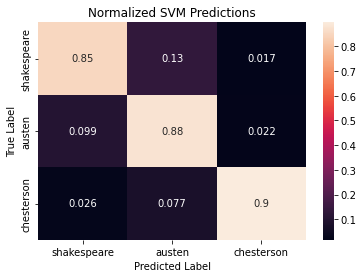

In [130]:
predictions = svc_model.predict(words_test)
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes=['shakespeare', 'austen', 'chesterson'], title='Normalized SVM Predictions')

## CNN

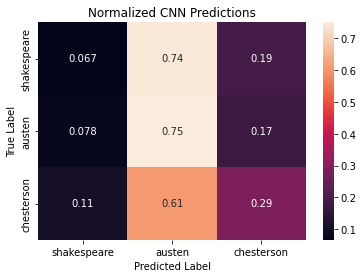

In [ ]:
# make predictions on test data
predictions = three_gram_model.predict([three_grams_test, three_grams_test, three_grams_test])
predictions = list(lb.inverse_transform(predictions))
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes=['shakespeare', 'austen', 'chesterson'], title='Normalized CNN Predictions')